# Water detection example

This method uses the steps described in:

_Donchyts, G., Schellekens, J., Winsemius, H., Eisemann, E., Van de Giesen, N., 2016. A 30 m resolution surface water mask including estimation of positional and thematic differences using landsat 8, srtm and openstreetmap: a case study in the Murray-Darling Basin, Australia. Remote Sensing 8, 386._

The examples below are somewhat optimized (by setting the configuration values) but more improvement and finetuning is possible. The example uses sentinel-2 data.

In [1]:
import rasterio
import os
from rasterio.mask import mask
import matplotlib.pyplot as plt
%matplotlib inline
from rasterio.plot import show
from xml.dom import minidom
import numpy as np
import geopandas as gpd
from dryspy import co_wdetect

We use the following three bands from sentinel-2 downloaded from EO browser for Scott River (CA) in this example:

- Band 3 – Green
- Band 8 – NIR
- Band 11 – SWIR	1613.7

In [2]:
B8_  = rasterio.open('EO_Browser_images/Scott-River/2022-10-29-00_00_2022-10-29-23_59_Sentinel-2_L2A_B08_(Raw).tiff') 
B11_  = rasterio.open('EO_Browser_images/Scott-River/2022-10-29-00_00_2022-10-29-23_59_Sentinel-2_L2A_B11_(Raw).tiff')
B3_ = rasterio.open('EO_Browser_images/Scott-River/2022-10-29-00_00_2022-10-29-23_59_Sentinel-2_L2A_B02_(Raw).tiff')

# Apply the scaling
B8 = B8_.read()
B11 = B11_.read()
B3 = B3_.read()



In [3]:
# Waterdetect assumes missing values are set to np.nan so we do that here
B8 = np.where(B8[0] <= 0.001, np.nan, B8)
B3 = np.where(B3[0] <= 0.001, np.nan, B3)
B11 = np.where(B11[0] <= 0.001, np.nan, B11)

# Next we calculate nwdi from swir and nir
ndwi_swir = (B3 - B11)/(B3 + B11)
ndwi_nir = (B3 - B8)/(B3 + B8)

First plot the three bands we use as well as the ndwi based on swir and nir

Text(0.5, 1.0, 'swir')

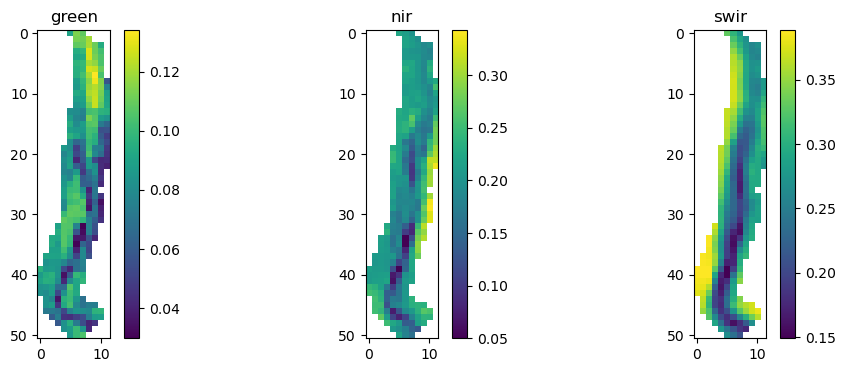

In [4]:
fig, ax =plt.subplots(1,3, figsize = (12,4))
im = ax[0].imshow(B3[0,:,:])
plt.colorbar(im)
im = ax[1].imshow(B8[0,:,:])
plt.colorbar(im)
im = ax[2].imshow(B11[0,:,:])
plt.colorbar(im)
ax[0].set_title('green')
ax[1].set_title('nir')
ax[2].set_title('swir')

Now detect water from nir and swir only

In [5]:
config = {"edge_detection": {
            "histogram_scale_maxvalue": 30,
            "histogram_scale_minvalue": 0,
            "sigma": 0.1,
            "classes": 4,
            "threshold_multiplication": 1.0,
            "buffer": 1
            },
            "data_clean": 
            {"min_size": 1,
            "dilation_erosion_size": 2
            },

}
wd = co_wdetect.canny_otsu_water_detect(config)
water_nir = wd.detect_water(B8[0,:,:].astype(float), th_direction='smaller')
nir_edges = wd.canny_buffedges.copy()

config = {"edge_detection": {
            "histogram_scale_maxvalue": 30,
            "histogram_scale_minvalue": 0,
            "sigma": 0.1,
            "classes": 2,
            "threshold_multiplication": 1.0,
            "buffer": 1
            },
            "data_clean": 
            {"min_size": 2,
            "dilation_erosion_size": 2
            },

}
wd = co_wdetect.canny_otsu_water_detect(config)
water_swir = wd.detect_water(B11[0,:,:].astype(float), th_direction='smaller', apply_secondary_filter=True, apply_uncertainty_filter=True)
swir_edges = wd.canny_buffedges.copy()

Text(0.5, 1.0, 'edges_swir')

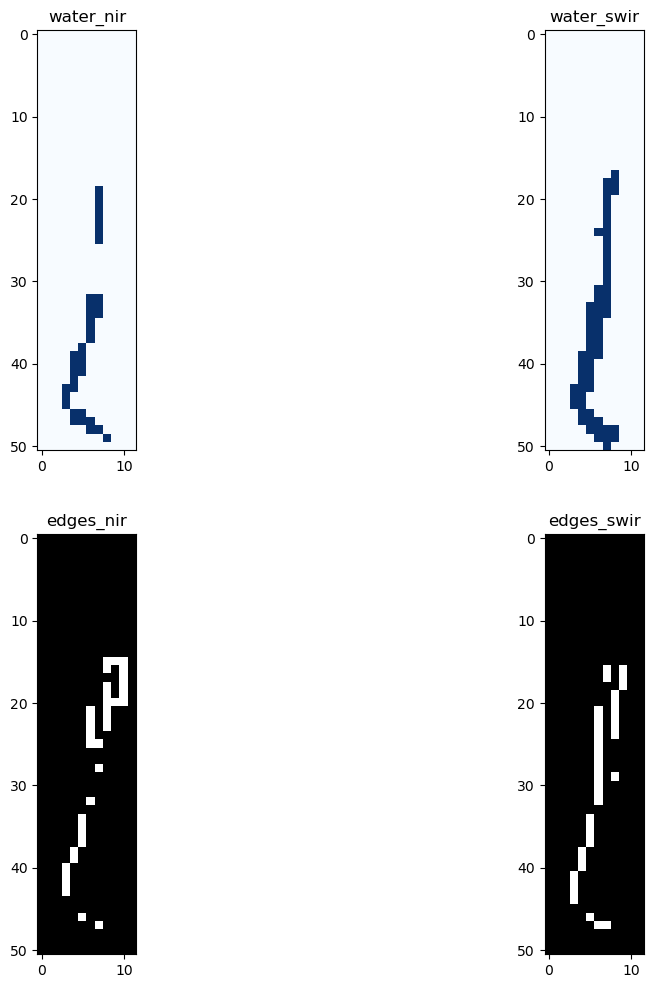

In [6]:
fig, ax =plt.subplots(2,2, figsize = (12,12))

im = ax[0,0].imshow(water_nir, vmin=0, vmax=1, cmap='Blues')
im = ax[0,1].imshow(water_swir, vmin=0, vmax=1, cmap='Blues')
ax[0,0].set_title('water_nir')
ax[0,1].set_title('water_swir')

im = ax[1,0].imshow(nir_edges, vmin=0, vmax=1, cmap='gray')
im = ax[1,1].imshow(swir_edges, vmin=0, vmax=1, cmap='gray')
ax[1,0].set_title('edges_nir')
ax[1,1].set_title('edges_swir')

Save the detected water using the different bands/indices as geotif files

In [ ]:
with rasterio.open(fp='water_nir.tif',
    mode="w",
    **B8_.meta,  # outputpath_name
) as dst:
    dst.write(np.array([water_nir]) * 10000)

with rasterio.open(fp='water_swir.tif',
    mode="w",
    **B8_.meta,  # outputpath_name
) as dst:
    dst.write(np.array([water_swir]) * 10000)

with rasterio.open(fp='water_ndwi_swir.tif',
    mode="w",
    **B8_.meta,  # outputpath_name
) as dst:
    dst.write(np.array([water_swir_ndwi]) * 10000)

with rasterio.open(fp='water_ndwi_nir.tif',
    mode="w",
    **B8_.meta,  # outputpath_name
) as dst:
    dst.write(np.array([water_nir_ndwi]) * 10000)

In [ ]:
import sys
wd.config.write(sys.stdout)

AttributeError: 'canny_otsu_water_detect' object has no attribute 'temporal_stats'